In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import autograd.numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

from utils.models import BNN, BNN_LV
from utils.functions import gaussian, log_gaussian
from utils.training import HMC
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs


In [2]:
# Data Loading
y_hsc, X_hsc = generate_regression_outputs(type='hsc')


In [3]:
# PDFs
# Set up the prior, likelihood and posterior
def log_prior(W, mu, sigma):
    """ Generate the prior PDF """
    return np.sum(log_gaussian(x=W, mu=mu, sigma=sigma), axis=-1)

# Set up the prior, likelihood and posterior
def log_latent_prior(z, mu, gamma):
    """ Generate the prior PDF """
    return np.sum(np.sum(log_gaussian(x=z, mu=mu, sigma=gamma), axis=-1), axis=-1)

def log_likelihood(W, X, Y, mu, sigma):
    """ Generate the likelihood PDF """
    llh = np.sum(log_gaussian(x=Y, mu=mu, sigma=sigma), axis=0)
    return llh

def create_log_posterior(X, Y, p_mu, p_sigma, l_sigma, nn, gamma):
    """ Wrapper to create an initialized posterior PDF """
    def log_posterior(W, X=X, Y=Y, p_mu=p_mu, p_sigma=p_sigma, l_sigma=l_sigma, nn=nn, gamma=gamma):
        """ Generate the posterior PDF """
        mu_l = nn.forward(X, weights=W)
        z = nn.last_input_noise
        log_p = log_prior(W=W, mu=p_mu, sigma=p_sigma)
        log_zp = log_latent_prior(z=z, mu=0, gamma=gamma)
        log_l = log_likelihood(W=W, X=X, Y=Y, mu=mu_l, sigma=l_sigma)
        llh = log_p + log_l + log_zp
        return llh 
    return log_posterior
    

In [6]:
# Parameters
gamma = 1
sigma = 1

architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma]}
bnn_lv = BNN_LV(architecture=architecture)

bnn_lv.fit(X_hsc, y_hsc, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)


Iteration 0 lower bound 10190.177283135057; gradient mag: 11132.720672202257
Iteration 500 lower bound 3.809404715622081; gradient mag: 2.627522678681711
Iteration 1000 lower bound 3.3964850873372407; gradient mag: 0.6059437539241243
Iteration 1500 lower bound 3.313417885846418; gradient mag: 0.34593444648070026
Iteration 2000 lower bound 3.285449088063738; gradient mag: 0.2652057995665322
Iteration 2500 lower bound 3.272458270389708; gradient mag: 0.21596354517110744
Iteration 3000 lower bound 3.261658030819048; gradient mag: 0.15156381211393927
Iteration 3500 lower bound 3.251264862143912; gradient mag: 0.1751226587511767
Iteration 4000 lower bound 3.2423575293532485; gradient mag: 0.22906186383861404
Iteration 4500 lower bound 3.231788132479446; gradient mag: 0.3562726258334264


In [9]:
# Create the posterior
log_posterior_bnn_lv = create_log_posterior(X_hsc, y_hsc, 0, 5, 0.25, bnn_lv, gamma=gamma)

# Run HMC from randiom intial starting weights
mle_weights = bnn_lv.get_weights()

hmc = HMC(log_target_func=log_posterior_bnn_lv, position_init=mle_weights, total_samples=1000, leapfrog_steps=50, step_size=1e-4,
    burn_in=0.5, thinning_factor=1, mass=1.0, random_seed=None, progress=False)

# Train the Model
bayesian_lv_weights = hmc.sample()

# Load a pretrained model
# hmc.load_state(filepath='../data/hmc/heteroscedastic_run1.json')
# bayesian_lv_weights = hmc.samples

/opt/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


KeyboardInterrupt: 

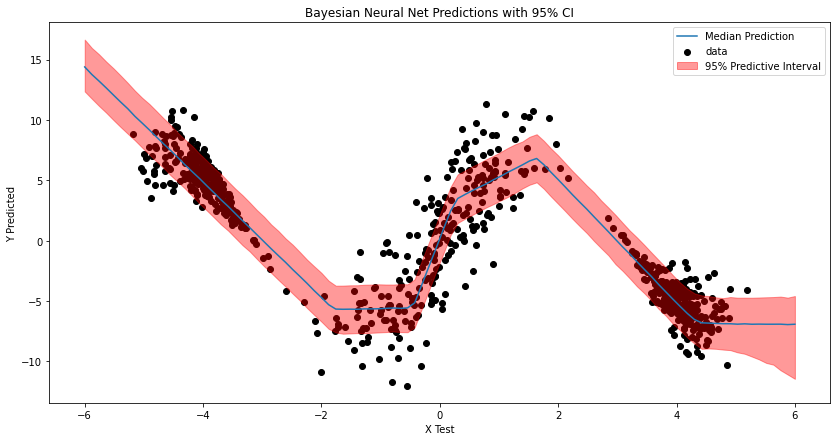

In [ ]:
# Set up data
x_test_q3 = np.linspace(-6, 6, 100)

# Take 100 random posterior samples
w_random_samples = bayesian_lv_weights[np.random.choice(bayesian_lv_weights.shape[0], 10000), :]

y_preds = []

# Loop through the samples of weights
for i in range(w_random_samples.shape[0]):
    # Create the same NN for predictions but with weights from the samples
    w_cur = w_random_samples[i,:]

    mu_pred = bnn_lv.forward(x_test_q3.reshape(-1,1), w_cur)
    y_pred = mu_pred
    y_preds.append(y_pred.reshape(-1))

# Calculate percentiles
y_lower = np.percentile(y_preds, q=2.5, axis=0)
y_upper = np.percentile(y_preds, q=97.5, axis=0)
y_med = np.percentile(y_preds, q=50, axis=0)

# Plot with confidence
plt.figure(figsize=(14,7))
plt.scatter(X_hsc.flatten(), y_hsc.flatten(), color='black', label='data')
plt.plot(x_test_q3, y_med, label="Median Prediction")
plt.fill_between(x_test_q3, y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
plt.title("Bayesian Neural Net Predictions with 95% CI")
plt.xlabel("X Test")
plt.ylabel("Y Predicted")
plt.legend()
plt.show()


In [ ]:
# Save the weights from HMC:
hmc.save_state(filepath='../data/hmc/heteroscedastic_run2.json', replace=True)

Saved HMC state : ../data/hmc/heteroscedastic_run1.json .
